<a href="https://colab.research.google.com/github/cdario79/FiltroFakeNews/blob/main/Filtro_per_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filtro per Fake News
Il problema delle fake news è cresciuto esponenzialmente nell'ultimo decennio a causa della crescente diffusione dei social network, il governo degli Stati Uniti ha deciso di muoversi a tal proposito, incaricando la tua azienda di realizzare un plug-in per chrome in grado di riconoscere se una notizia è falsa. Il tuo compito è quello di realizzare il modello in grado di riconoscere le notizie false, che poi il team di machine learning enginner e web developer metterà in produzione. Ti vengono messi a disposizioni due raccolte di notizie, una contenente solo notizie false e l'altra contenente solo notizie vere, utilizzale per addestrare il tuo modello.

### [Link al dataset](https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip)

Parti da un'accurata analisi, rispondendo a domande come:
- le fake news sono più frequenti in una determinata categoria?
- per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?
- I titoli delle fake news presentano dei pattern?

Una volta addestrato il modello esportalo [utilizzando pickle](https://scikit-learn.org/stable/model_persistence.html) così che i tuoi colleghi possano metterlo in produzione.

## IMPORTAZIONE LIBRERIE UTILIZZATE

In [70]:
!pip install pyldavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.8 MB/s eta 0:00:00


In [87]:
# Importing necessary libraries for data manipulation and analysis
import re  # Regular expressions for text processing
import os  # Operating system functionalities
import requests  # HTTP requests to access web content
import unicodedata  # Import the unicodedata module to work with Unicode character properties and normalization.
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# Importing libraries for data visualization
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization
from wordcloud import WordCloud  # Word cloud visualization

# Importing libraries for natural language processing (NLP)
import nltk  # Natural language processing toolkit
from nltk.corpus import stopwords  # List of common stopwords
from nltk.util import ngrams  # Generating n-grams
from nltk import word_tokenize, pos_tag, ne_chunk  # Tokenization, part-of-speech tagging, named entity recognition
from collections import Counter  # Counter for counting occurrences
nltk.download('stopwords')  # Downloading stopwords corpus
nltk.download('punkt')  # Downloading Punkt tokenizer models
nltk.download('averaged_perceptron_tagger')  # Downloading averaged perceptron tagger
nltk.download('maxent_ne_chunker')  # Downloading maxent named entity chunker
nltk.download('words')  # Downloading words corpus used by the named entity chunker

# Importing libraries for machine learning
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF vectorizer for text data
from sklearn.model_selection import train_test_split  # Splitting data into train and test sets
from sklearn.svm import SVC  # Support Vector Machine classifier
from sklearn.metrics import accuracy_score, classification_report  # Metrics for model evaluation

# Importing libraries for topic modeling
from gensim import corpora, models  # Libraries for topic modeling
from gensim.models import CoherenceModel  # Coherence model for topic coherence evaluation

# Importing library for interactive display
from IPython.display import display, HTML  # Rich output display in Jupyter notebooks

# Importing library for serialization
import pickle  # Serialization and deserialization of Python objects

# Importing the pyLDAvis library
import pyLDAvis  # Interactive topic model visualization
import pyLDAvis.gensim_models as gensimvis  # Gensim models for pyLDAvis integration

# Importing library for handling warnings
import warnings  # Warning control
warnings.filterwarnings('ignore')  # Ignore all warnings

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## FUNZIONI UTILIZZATE

In [2]:
def download_csv_from_google_drive(file_id):
    """
    Downloads a CSV file from Google Drive given the file_id.

    Args:
        file_id (str): The unique identifier for the Google Drive file.

    Returns:
        str: The absolute path to the downloaded file.
    """

    def get_confirm_token(response):
        """
        Retrieves the confirmation token from the response cookies if present.

        Args:
            response (requests.Response): The response object from the initial request.

        Returns:
            str: The confirmation token if found, otherwise None.
        """
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        """
        Saves the content of the response to a file in chunks.

        Args:
            response (requests.Response): The response object containing the file data.
            destination (str): The destination path where the file will be saved.
        """
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:  # Filter out keep-alive new chunks
                    f.write(chunk)

    def download_file_from_google_drive(file_id, destination):
        """
        Handles the download process from Google Drive, managing potential confirmation tokens.

        Args:
            file_id (str): The unique identifier for the Google Drive file.
            destination (str): The destination path where the file will be saved.
        """
        URL = "https://drive.google.com/uc?export=download"
        session = requests.Session()

        response = session.get(URL, params={'id': file_id}, stream=True)
        token = get_confirm_token(response)

        if token:
            params = {'id': file_id, 'confirm': token}
            response = session.get(URL, params=params, stream=True)

        save_response_content(response, destination)

    file_name = f"{file_id}.csv"

    if not os.path.exists(file_name):
        print(f"File {file_name} non trovato. Scaricamento in corso ...")
        download_file_from_google_drive(file_id, file_name)
        print(f"File {file_name} scaricato correttamente.")
    else:
        print(f"File {file_name} già presente.")

    return os.path.abspath(file_name)

In [88]:
def slugify(value, allow_unicode=False):
    """
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

In [3]:
def create_wordcloud(text):
    """
    Generates a word cloud visualization from the input text.

    Args:
        text (list of str): A list of strings representing the text data.

    Returns:
        None
    """
    # Create WordCloud object with specified width, height, and background color
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(text))

    # Set up the plot size
    plt.figure(figsize=(10, 5))

    # Display the word cloud image with bilinear interpolation
    plt.imshow(wordcloud, interpolation='bilinear')

    # Turn off the axis
    plt.axis('off')

    # Show the plot
    plt.show()

In [82]:
def preprocess_text(text):
    """
    Preprocesses the input text by tokenizing, removing stop words, punctuation, and short words.
    Also generates bigrams and trigrams.

    Args:
        text (str): The input text to be preprocessed.

    Returns:
        list of str: The preprocessed tokens including bigrams and trigrams.
    """
    # Convert to lowercase
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # Remove words with 3 letters or less
    tokens = [word for word in tokens if len(word) > 3]

    # Generate bigrams and trigrams
    bigrams = ['_'.join(bigram) for bigram in ngrams(tokens, 2)]
    trigrams = ['_'.join(trigram) for trigram in ngrams(tokens, 3)]

    # Combine original tokens with bigrams and trigrams
    all_ngrams = tokens + bigrams + trigrams

    return all_ngrams

In [5]:
def get_most_relevant_topic(lda_result):
    """
    Retrieves the most relevant topic from the LDA result.

    Args:
        lda_result (list of tuples): The result of LDA analysis, where each tuple contains a topic and its corresponding probability.

    Returns:
        int or None: The index of the most relevant topic, or None if the input is empty.
    """
    if lda_result:
        # Find the topic with the highest probability
        return max(lda_result, key=lambda x: x[1])[0]
    else:
        return None

In [90]:
def analyze_topic(category_df, category_name, num_topics=5, alpha='auto', eta='auto', iterations=1000, passes=10):
    """
    Analyzes the topic of documents in the given category DataFrame using LDA (Latent Dirichlet Allocation) and visualizes the results.

    Args:
        category_df (DataFrame): DataFrame containing documents in the category.
        category_name (str): Name of the category.

    Returns:
        None
    """
    category_documents = category_df['document'].tolist()

    # Get total number of articles
    total_documents = len(category_documents)

    # Prepare text for LDA
    texts = [preprocess_text(doc) for doc in category_documents]

    # Create dictionary
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Train LDA model
    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        alpha=alpha,
        eta=eta,
        iterations=iterations,
        passes=passes,
        random_state=42
    )

    # Calculate perplexity
    log_perplexity = lda_model.log_perplexity(corpus)
    perplexity = 2**(-log_perplexity)

    # Normalize perplexity to the range [0, 1]
    normalized_perplexity = 1 / (1 + perplexity)

    # Calculate coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    # Formatted text for display
    formatted_text_val = "<h2>Valutazione del modello per la categoria  \"" + category_name.upper() + "\"</h2>"
    formatted_text_val += "<p>Perplexity: " + str(round(normalized_perplexity,5)) + "</p>"
    formatted_text_val += "<p>Coherence Score: " + str(round(coherence_lda,5)) + "</p>"
    formatted_text_val += "<p>&nbsp;</p>"

    # Display formatted text
    display(HTML(formatted_text_val))

    # Create the visualization of the topics
    lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)

    # Calculate Category Slug
    category_slug = slugify(category_name);

    # Save the visualization to an HTML file
    pyLDAvis.save_html(lda_vis, 'lda_'+category_slug+'.html')

    # Display the visualization
    display(HTML('lda_'+category_slug+'.html'))

    print()

    # Extract topics
    topics = lda_model.print_topics(num_words=5)

    # Sort keywords within each topic by importance
    sorted_topics = [(topic_num, sorted(topic_str.split(" + "), key=lambda x: float(x.split("*")[0]), reverse=True)) for topic_num, topic_str in topics]

    # Formatted text in HTML
    formatted_text = "<h2>Argomenti per la categoria " + category_name.upper() + ":</h2>"
    formatted_text += "<ul>"
    for topic_num, topic_words in sorted_topics:
        # Extract only words and their weights
        words_with_weights = [word_weight.split("*") for word_weight in topic_words]

        # Create HTML format for each topic
        topic_html = "<li><strong>Argomento {}:</strong><ul>".format(topic_num)
        for word, weight in words_with_weights:
            # Add importance value next to each word
            topic_html += "<li>{}: {}</li>".format(word.strip('\"'), weight)
        topic_html += "</ul></li>"

        formatted_text += topic_html

    formatted_text += "</ul>"

    # Display formatted text
    display(HTML(formatted_text))

    # Add LDA result to DataFrame
    lda_results = [lda_model[dictionary.doc2bow(text)] for text in texts]

    # Sort lda_results from most important to least important
    lda_results_sorted = [sorted(result, key=lambda x: x[1], reverse=True) for result in lda_results]

    most_relevant_topics = [get_most_relevant_topic(result) for result in lda_results_sorted]

    # Add column with most relevant topic number
    category_df['lda_topic'] = lda_results_sorted
    category_df['most_relevant_topic'] = most_relevant_topics

    print()

    # Count frequency of each topic
    topic_counts = category_df['most_relevant_topic'].value_counts().sort_index()

    # Visualizing the distribution of topics within a category using a bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size

    # Calculate percentages of topic occurrences relative to total documents
    percentages = (topic_counts / total_documents) * 100

    # Sort topic counts in descending order
    topic_counts_sorted = topic_counts.sort_values(ascending=False)

    # Create the bar plot
    bars = sns.barplot(x=topic_counts_sorted.index, y=topic_counts_sorted, order=topic_counts_sorted.index)

    # Annotate each bar with its count and percentage
    for bar, perc in zip(bars.patches, percentages):
        bars.annotate(f"{format(bar.get_height(), '.0f')} ({perc:.2f}%)",
                      (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                      ha='center', va='center',
                      size=12, xytext=(0, 8),
                      textcoords='offset points')

    # Plot config
    plt.title(f'Frequenza argomenti per categoria {category_name.upper()} su {total_documents} articoli totali')
    plt.xlabel('Argomenti')
    plt.ylabel('Numero di articoli')
    plt.ylim(0, topic_counts.max() * 1.2)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print()
    display(HTML(f'<h2>Parole più frequenti nella categoria {category_name.upper()}</h2>'))
    print()

    # Create a word cloud
    all_words = [word for doc in category_documents for word in preprocess_text(doc)]
    create_wordcloud(all_words)

La formula:

<code>perplexity = 2**(-log_perplexity)</code>

serve per convertire la perplessità logaritmica in perplessità nel contesto della modellazione del topic con LDA.

Quando valutiamo un modello LDA utilizzando Gensim, il metodo log_perplexity restituisce il logaritmo della perplexity. Questo perché prendere il logaritmo della perplexity può semplificare i calcoli e migliorare la stabilità numerica, specialmente quando si lavora con probabilità molto piccole.

Tuttavia, nella pratica, preferiamo di solito riportare la perplessità come un valore scalare positivo. Per ottenere questo, esponenziamo la perplexity logaritmica, percui la formula sopracitata è usata perché corrisponde all'operazione inversa del logaritmo in base 2, che è comunemente usato in compiti di elaborazione del linguaggio naturale (NLP).

Quindi, esponenziando il negativo del logaritmo della perplexity utilizzando la base 2, otteniamo un valore scalare positivo che rappresenta la perplexity del modello. Questo valore è riportato nell'intervallo 0-1, rendendolo più facile da interpretare e confrontare tra diversi modelli o esperimenti.

## CARICO E ANALIZZO LE NOTIZIE VERE

In [7]:
# Downloading the True News CSV file from Google Drive with the specified file ID
original_true_news_csv_path = download_csv_from_google_drive('1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f')

File 1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f.csv non trovato. Scaricamento in corso ...
File 1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f.csv scaricato correttamente.


In [8]:
# Read the True News CSV file into a pandas DataFrame
df_true = pd.read_csv(original_true_news_csv_path)

# Display a random sample of 10 rows from the DataFrame
df_true.sample(10)

,title,text,subject,date
5621,U.S. House passes bill requiring warrants to s...,WASHINGTON (Reuters) - The U.S. House of Repr...,politicsNews,"February 6, 2017"
316,Mueller's Russia probe cost his office $3.2 mi...,WASHINGTON (Reuters) - U.S. Special Counsel Ro...,politicsNews,"December 5, 2017"
656,Silicon Valley blasts Senate proposal to tax s...,SAN FRANCISCO (Reuters) - A proposal by the U....,politicsNews,"November 14, 2017"
12309,Do not expect postcard-sized tax return from R...,"WASHINGTON (Reuters) - Since mid-2016, U.S. Ho...",worldnews,"December 14, 2017"
1665,"As clock ticks, Republicans try to move ahead ...",WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"September 19, 2017"
6330,Trump adviser Flynn spoke to Russian envoy Dec...,WASHINGTON (Reuters) - President-elect Donald ...,politicsNews,"January 13, 2017"
20147,UK PM May to make Brexit speech in Italy on Se...,LONDON (Reuters) - Prime Minister Theresa May ...,worldnews,"September 13, 2017"
2054,Trump unshackled: President defends Charlottes...,PHOENIX (Reuters) - U.S. President Donald Trum...,politicsNews,"August 22, 2017"
14077,Czech president plans to appoint Babis's cabin...,PRAGUE (Reuters) - Czech President Milos Zeman...,worldnews,"November 23, 2017"
6050,Trump's defense chief eyes debut trip to Japan...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"January 25, 2017"


In [9]:
# Check the shape of the DataFrame
df_true.shape

(21417, 4)

In [10]:
# Check for missing values in the DataFrame
df_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [11]:
# Count the number of empty titles in the DataFrame
df_true.title[df_true.title.str.strip() == ''].count()

0

In [12]:
# Count the number of empty texts in the DataFrame
df_true.text[df_true.text.str.strip() == ''].count()

1

In [21]:
# Filter rows with empty text in the DataFrame
true_text_empty_row = df_true[df_true['text'].str.strip() == '']

# Display rows with empty text
true_text_empty_row

,title,text,subject,date
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016"


In [14]:
# Check for duplicated rows in the DataFrame
df_true.duplicated().sum()

206

In [18]:
# Filter duplicated rows in the DataFrame
true_duplicated_rows = df_true[df_true.duplicated(keep=False)]

# Display duplicated rows
true_duplicated_rows.head(10)

,title,text,subject,date
416,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017"
445,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017"
762,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017"
778,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017"
850,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"November 2, 2017"
874,Trump taps Fed centrist Powell to lead U.S. ce...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"November 2, 2017"
892,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"November 2, 2017"
896,Trump taps Fed centrist Powell to lead U.S. ce...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"November 2, 2017"
949,"Two ex-Trump aides charged in Russia probe, th...",WASHINGTON (Reuters) - Federal investigators p...,politicsNews,"October 30, 2017"
974,"Two ex-Trump aides charged in Russia probe, th...",WASHINGTON (Reuters) - Federal investigators p...,politicsNews,"October 30, 2017"


## CARICO E ANALIZZO LE NOTIZIE FALSE

In [19]:
# Downloading the Fake News CSV file from Google Drive with the specified file ID
original_fake_news_csv_path = download_csv_from_google_drive('1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m')

File 1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m.csv non trovato. Scaricamento in corso ...
File 1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m.csv scaricato correttamente.


In [20]:
# Read the Fake News CSV file into a pandas DataFrame
df_fake = pd.read_csv(original_fake_news_csv_path)

# Display the first few rows of the DataFrame
df_fake.sample(10)

,title,text,subject,date
18782,ARROGANT Former ILLEGAL ALIEN Brags About Usin...,"Julissa Arce, who is now a Vice President at G...",left-news,"Apr 21, 2017"
18605,CA: STATE LEGISLATORS Want Traffic Fines To Be...,"Punishing rich, hard-working, white Americans ...",left-news,"May 19, 2017"
1244,"WATCH: Colbert GOES THERE, Calls For A New El...",Late Show host Stephen Colbert has been having...,News,"June 7, 2017"
19118,AWESOME! HISPANIC TRUMP SUPPORTER Rips Into Pr...,,left-news,"Feb 19, 2017"
16609,[Video] DUMB AND DUMBER Star BASHES TRUMP…Use ...,Jeff Daniels channels his role as ACN s Will ...,Government News,"May 13, 2016"
573,Tortured Snowflake Ivanka Trump Just Blocked ...,"Apparently, Donald Trump s precious little gir...",News,"August 13, 2017"
8887,‘Pissed As Hell’ Oregon Rancher FURIOUS At Bu...,Georgia Marshall has had just about enough of ...,News,"January 8, 2016"
10853,LEGAL EXPERT JONATHAN TURLEY Shoots Down Joe S...,Legal Expert Jonathan Turley listened as Joe S...,politics,"May 17, 2017"
13970,BREAKING BOMBSHELL: Obama’s Foreign Policy Gur...,"As if this news, in and of itself, is not horr...",politics,"May 6, 2016"
19629,SORRY LIBERALS…You Can Stop With The Petitions...,"Okay, let s address this Hillary might win th...",left-news,"Nov 12, 2016"


In [22]:
# Check the shape of the DataFrame
df_fake.shape

(23481, 4)

In [23]:
# Check for missing values in the DataFrame
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [24]:
# Count the number of empty titles in the DataFrame
df_fake.title[df_fake.title.str.strip() == ''].count()

0

In [25]:
# Count the number of empty texts in the DataFrame
df_fake.text[df_fake.text.str.strip() == ''].count()

630

In [28]:
# Filter rows with empty text in the DataFrame
fake_text_empty_row = df_fake[df_fake['text'].str.strip() == '']

# Display rows with empty text
fake_text_empty_row

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [29]:
# Check for duplicated rows in the DataFrame
df_fake.duplicated().sum()

3

In [30]:
# Filter duplicated rows in the DataFrame
fake_duplicated_rows = df_fake[df_fake.duplicated(keep=False)]

# Display duplicated rows
fake_duplicated_rows

,title,text,subject,date
9941,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
11445,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
14924,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"
14925,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"


## LE FAKE NEWS SONO PIU' FREQUENTI IN UNA DETERMINATA CATEGORIA?

In [31]:
# Drop duplicates from the DataFrame based on all columns
df_fake_cat = df_fake.drop_duplicates()

# Keep only the 'subject' column
df_fake_cat = df_fake_cat[['subject']]

# Display a random sample of 10 rows from the DataFrame
df_fake_cat.sample(10)

,subject
7421,News
17846,left-news
5278,News
1622,News
11966,politics
43,News
19259,left-news
18764,left-news
20527,left-news
5682,News


In [32]:
# Check the shape of the DataFrame
df_fake_cat.shape

(23478, 1)

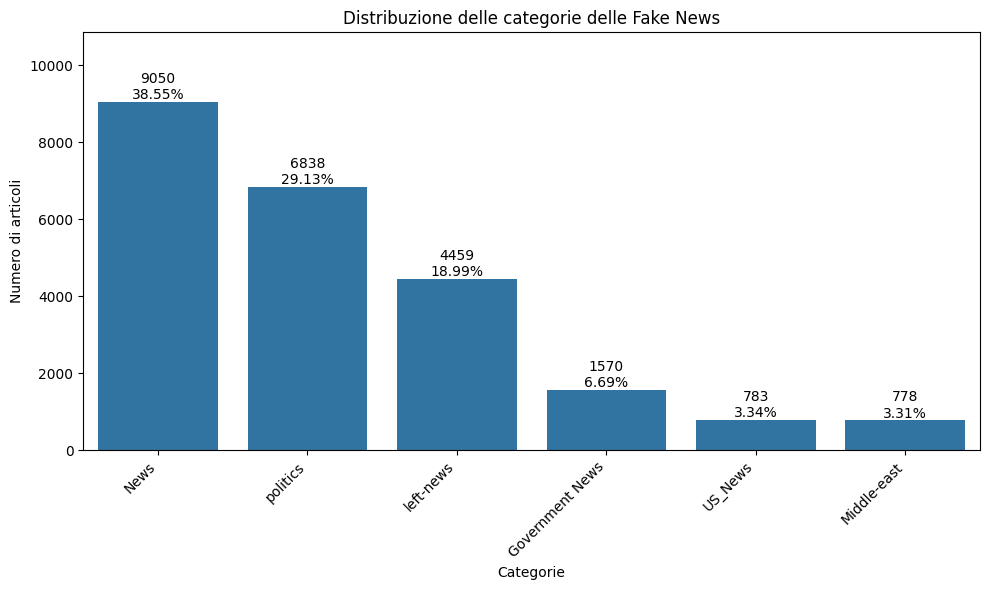

In [33]:
# Calculate the counts of values in the DataFrame
counts = df_fake_cat['subject'].value_counts()

# Calculate the percentage relative to the total
percentages = counts / counts.sum() * 100

# Sort the counts from highest to lowest
counts_sorted = counts.sort_values(ascending=False)

# Create the countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=df_fake_cat['subject'], order=counts_sorted.index)
for i, (index, count) in enumerate(counts_sorted.items()):
    plt.text(i, count + 70, f'{count}\n{percentages[index]:,.2f}%', ha='center', color='black')

# Set the range of the y-axis
plt.ylim(0, counts.max() * 1.2)

plt.title('Distribuzione delle categorie delle Fake News')
plt.xlabel('Categorie')
plt.ylabel('Numero di articoli')
 # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()

Le FAKE NEWS sono più presenti nella categoria delle notizie generiche (NEWS), questo potrebbe essere dovuto a diversi fattori:

- **Ampia diffusione**: Le fake news possono essere create e diffuse su argomenti di interesse generale per raggiungere un pubblico più ampio. Poiché le notizie generiche potrebbero attrarre più persone, i creatori di fake news potrebbero mirare a questa categoria per massimizzare la loro portata.

- **Mancanza di verifica**: Le notizie generiche potrebbero ricevere meno attenzione da parte di coloro che controllano i fatti o la veridicità delle informazioni, permettendo alle fake news di diffondersi più facilmente in questo contesto.

- **Maggiore ambiguità**: Gli argomenti generici potrebbero offrire più spazio per l'interpretazione e l'ambiguità, il che potrebbe rendere più difficile per il pubblico distinguere tra notizie genuine e fake news.

- **Mancanza di approfondimento**: Poiché le notizie generiche non si concentrano su un argomento specifico, potrebbero ricevere meno attenzione e approfondimento da parte dei lettori, che potrebbero quindi essere più inclini a credere a informazioni non verificate o false.


## PER OGNI CATEGORIA, CI SONO ARGOMENTI CHE SONO PIU' SOGGETTI ALLE FAKE NEWS?

In [34]:
# Remove duplicate rows from the DataFrame and create a new DataFrame
df_fake_cat_topic = df_fake.drop_duplicates()

# Concatenate the 'title' and 'text' columns to create a new column 'document'
# This combines the title and text of each entry into a single document
df_fake_cat_topic['document'] = df_fake_cat_topic['title'] + " " + df_fake_cat_topic['text']

# Select only the 'subject' and 'document' columns from the DataFrame
# This discards any other columns from the DataFrame
df_fake_cat_topic = df_fake_cat_topic[['subject', 'document']]

# Randomly sample 10 rows from the DataFrame and display them
# This allows for a quick inspection of a subset of the processed data
df_fake_cat_topic.sample(10)

,subject,document
606,News,Walmart Forced To Apologize After Store Tells...
19903,left-news,IS OUR FIRST AMENDMENT RIGHT Being Stolen By T...
20123,left-news,MUSLIMS SILENT AFTER TERROR ATTACKS…BUT BLAME ...
12014,politics,"TRUMP KICKS Pro-Amnesty, Globalist Koch Brothe..."
22023,US_News,Zakharova Slams CIA Chief Pompeo: Stop Making ...
17527,left-news,POCAHONTAS CALLS Trump’s Comments To Dem Senat...
18287,left-news,"REAL INDIAN, GOP Senate Hopeful Shiva Ayyadura..."
13846,politics,HERE’S WHY TRUMP’S Muslim Ban Is Absolutely Ne...
15579,politics,ARMY THREATENS GREEN BERET WAR HERO WITH COURT...
9092,politics,JUST IN: TRUMP ENDS FREE MONEY TRAIN After Pak...


In [35]:
# Extract unique categories from the 'subject' column of the DataFrame
categories_fake = list(df_fake_cat_topic['subject'].unique())

# Convert the unique categories into a list
# The 'unique()' function returns an array of unique values in the 'subject' column
# 'list()' converts this array into a Python list
categories_fake

['News', 'politics', 'Government News', 'left-news', 'US_News', 'Middle-east']

In [ ]:
# Define the current category name
current_category_name = 'News'

# Define LDA params
params = {
    'num_topics': 6,
    'alpha': 'auto',
    'eta': 'auto',
    'iterations': 250,
    'passes': 10
}

# Filter the DataFrame to only include rows where the 'subject' column matches the current category name
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]

# Pass the filtered DataFrame and the current category name to a function to analyze topic
analyze_topic(current_category_df, current_category_name, **params)

In [ ]:
# Define the current category name
current_category_name = 'politics'

# Define LDA params
params = {
    'num_topics': 4,
    'alpha': 0.1,
    'eta': 0.1,
    'iterations': 1000,
    'passes': 10
}

# Filter the DataFrame to only include rows where the 'subject' column matches the current category name
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]

# Pass the filtered DataFrame and the current category name to a function to analyze topic
analyze_topic(current_category_df, current_category_name, **params)

In [ ]:
# Define the current category name
current_category_name = 'Government News'

# Define LDA params
params = {
    'num_topics': 4,
    'alpha': 0.1,
    'eta': 0.1,
    'iterations': 1000,
    'passes': 10
}

# Filter the DataFrame to only include rows where the 'subject' column matches the current category name
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]

# Pass the filtered DataFrame and the current category name to a function to analyze topic
analyze_topic(current_category_df, current_category_name, **params)

In [ ]:
# Define the current category name
current_category_name = 'left-news'

# Define LDA params
params = {
    'num_topics': 4,
    'alpha': 0.1,
    'eta': 0.1,
    'iterations': 1000,
    'passes': 10
}

# Filter the DataFrame to only include rows where the 'subject' column matches the current category name
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]

# Pass the filtered DataFrame and the current category name to a function to analyze topic
analyze_topic(current_category_df, current_category_name, **params)

In [ ]:
# Define the current category name
current_category_name = 'US_News'

# Define LDA params
params = {
    'num_topics': 4,
    'alpha': 0.1,
    'eta': 0.1,
    'iterations': 1000,
    'passes': 10
}

# Filter the DataFrame to only include rows where the 'subject' column matches the current category name
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]

# Pass the filtered DataFrame and the current category name to a function to analyze topic
analyze_topic(current_category_df, current_category_name, **params)

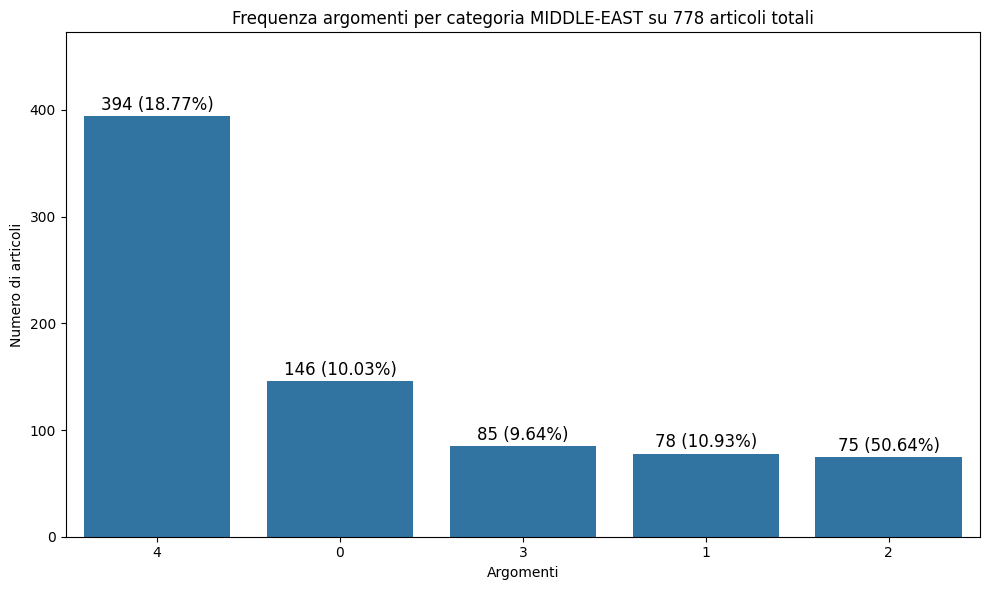

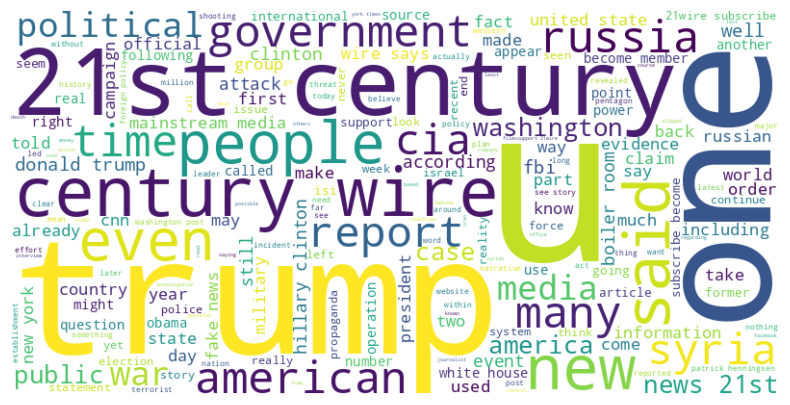

In [75]:
# Define the current category name
current_category_name = 'Middle-east'

# Define LDA params
params = {
    'num_topics': 4,
    'alpha': 0.1,
    'eta': 0.1,
    'iterations': 1000,
    'passes': 10
}

# Filter the DataFrame to only include rows where the 'subject' column matches the current category name
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]

# Pass the filtered DataFrame and the current category name to a function to analyze topic
analyze_topic(current_category_df, current_category_name, **params)

## I titoli delle fake news presentano dei pattern?

Per determinare se i titoli delle fake news presentano dei pattern, possiamo utilizzare diverse tecniche, tra cui l'analisi delle parti del discorso (POS) e il riconoscimento delle entità nominate (NER), insieme ad altri metodi di analisi del testo.

Ecco come possiamo procedere utilizzando POS e NER:

Analisi delle parti del discorso (POS): Con POS, possiamo identificare i ruoli grammaticali di ciascuna parola nei titoli delle fake news. Ad esempio, possiamo vedere se ci sono schemi comuni nell'uso di determinate categorie di parole (come nomi, verbi, aggettivi) nei titoli delle fake news.

Riconoscimento delle entità nominate (NER): Con NER, possiamo identificare e classificare le entità nominate nei titoli delle fake news, come persone, luoghi, organizzazioni, ecc. Questo ci aiuta a capire se ci sono determinati soggetti o argomenti ricorrenti nelle fake news.

Analisi delle parole chiave e delle frasi: Possiamo esaminare le parole chiave e le frasi più frequenti nei titoli delle fake news per identificare pattern o temi ricorrenti.

Visualizzazione dei risultati: Utilizziamo grafici, nuvole di parole o altri strumenti di visualizzazione per rappresentare i pattern identificati nei titoli delle fake news in modo chiaro e comprensibile.


In [ ]:
df_fake_title = df_fake.drop_duplicates()
df_fake_title = df_fake_title[['title']]
print(df_fake_title.shape)
df_fake_title.sample(10)

                                                   title
0       Donald Trump Sends Out Embarrassing New Year’...
1       Drunk Bragging Trump Staffer Started Russian ...
2       Sheriff David Clarke Becomes An Internet Joke...
3       Trump Is So Obsessed He Even Has Obama’s Name...
4       Pope Francis Just Called Out Donald Trump Dur...
...                                                  ...
23476  McPain: John McCain Furious That Iran Treated ...
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
23479  How to Blow $700 Million: Al Jazeera America F...
23480  10 U.S. Navy Sailors Held by Iranian Military ...

[23478 rows x 1 columns]


,title
1905,Dem. Senator Promises To Filibuster Gorsuch B...
15984,FACTORY WORKER RIPS INTO Speaker Paul Ryan on ...
4864,WATCH: Scottie Nell Hughes Calls Clinton A Bi...
19525,BREAKING: CONDI RICE Meets With Mike Pence In ...
15278,SAY WHAT? #BlackLivesMatter TEXTBOOKS TO BE US...
21246,U.S. Air Force Runs Out Of Bombs To Drop On IS...
4761,Obama Shows Why Trump Is Too Much Of A Hothea...
4411,WATCH: Bill Maher Hilariously TORCHES Whiny T...
1808,Trump Campaign Manager Registering As Foreign...
9031,"Jeb! Makes Awkward ‘Hurricane Katrina’ Joke, ..."


In [ ]:
#  titoli delle fake news
fake_titles = df_fake_title['title']

# Tokenizzazione e POS tagging
pos_tags = []
for title in fake_titles:
    words = word_tokenize(title)
    pos_tags.extend(pos_tag(words))

# Conteggio delle parti del discorso più comuni
pos_counts = Counter(tag for word, tag in pos_tags)

# Riconoscimento delle entità nominate (NER)
ner_tags = []
for title in fake_titles:
    words = word_tokenize(title)
    ner_tags.extend(ne_chunk(pos_tag(words)))

# Estrazione delle entità nominate
named_entities = [chunk for chunk in ner_tags if hasattr(chunk, 'label')]

# Visualizzazione dei risultati
print("Parti del discorso più comuni:")
print(pos_counts)
print("\nEntità nominate:")
print(named_entities[:10])

Parti del discorso più comuni:
Counter({'NNP': 254649, 'IN': 29430, 'NN': 19159, 'JJ': 10547, 'DT': 9381, 'TO': 8774, ':': 8671, 'VBD': 7375, 'VBZ': 6703, 'PRP': 6626, 'VB': 6483, '.': 5930, 'NNS': 5071, 'VBG': 4521, ',': 4490, '(': 4131, ')': 4131, 'VBP': 3859, 'RB': 3795, 'CD': 3654, 'CC': 3637, 'NNPS': 2720, 'PRP$': 2655, 'VBN': 1565, 'WRB': 1524, 'WP': 943, 'MD': 923, '#': 804, 'RP': 736, '$': 517, 'JJR': 343, 'WDT': 265, 'JJS': 187, 'EX': 170, 'POS': 127, 'UH': 97, 'PDT': 97, 'RBR': 93, 'FW': 71, 'RBS': 57, "''": 27})

Entità nominate:
[Tree('PERSON', [('Donald', 'NNP')]), Tree('PERSON', [('Trump', 'NNP')]), Tree('GPE', [('New', 'NNP')]), Tree('PERSON', [('Eve', 'NNP'), ('Message', 'NNP')]), Tree('PERSON', [('Drunk', 'NNP')]), Tree('ORGANIZATION', [('Bragging', 'NNP'), ('Trump', 'NNP'), ('Staffer', 'NNP')]), Tree('GPE', [('Russian', 'NNP')]), Tree('PERSON', [('Sheriff', 'NN')]), Tree('PERSON', [('David', 'NNP'), ('Clarke', 'NNP'), ('Becomes', 'NNP'), ('An', 'DT'), ('Internet', 'NN

Sì, i titoli delle fake news spesso presentano alcuni pattern ricorrenti nelle parti del discorso. Tuttavia, i modelli esatti possono variare a seconda del contesto e delle tendenze specifiche delle fake news in un dato momento. Alcuni pattern comuni potrebbero includere un'elevata frequenza di nomi propri (NNP) per attirare l'attenzione sugli argomenti o sulle persone coinvolte, un alto numero di aggettivi (JJ) per enfatizzare certi aspetti dell'articolo, e una frequenza significativa di verbi (VB) per creare un senso di azione o dramma nel titolo.

Alcuni esempi di pattern potrebbero essere:

L'uso di nomi propri seguiti da verbi o aggettivi forti per creare impatto emotivo.
Una frequenza elevata di verbi al passato (VBD) per dare un senso di autorità o veridicità.
La presenza di pronomi personali (PRP) o pronomi possessivi (PRP$) per rendere il titolo più coinvolgente.
L'uso di avverbi (RB) per aumentare l'intensità del messaggio.
Tuttavia, è importante notare che queste sono solo possibili tendenze e che i titoli delle fake news possono variare ampiamente nel loro stile e nella loro struttura.

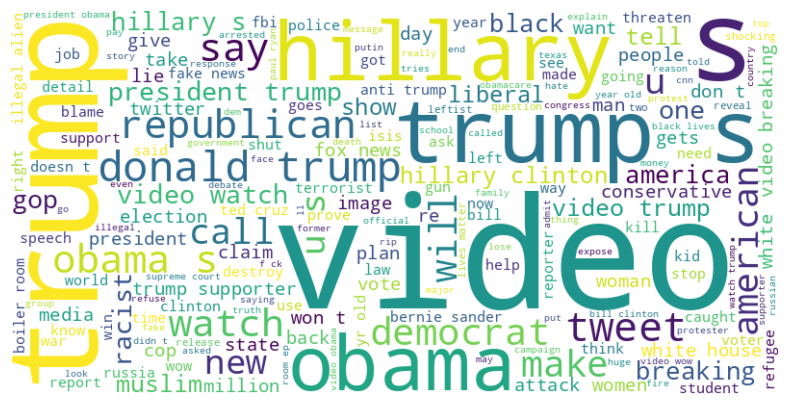

In [ ]:
# Estrazione delle parole dai titoli delle fake news
words_fake = [word.lower() for title in fake_titles for word in word_tokenize(title)]

# Creazione della nuvola di parole
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words_fake))

# Visualizzazione della nuvola di parole
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Creazione modello per identificare fake news

In [ ]:
df_true_cleaned = df_true.drop_duplicates()
df_true_cleaned['document'] = df_true_cleaned['title'] + " " + df_true_cleaned['text']
df_true_cleaned = df_true_cleaned[['document']]
df_true_cleaned["label"] = 0
df_true_cleaned

,document,label
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0
...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,0
21413,LexisNexis withdrew two products from Chinese ...,0
21414,Minsk cultural hub becomes haven from authorit...,0
21415,Vatican upbeat on possibility of Pope Francis ...,0


In [ ]:
df_fake_cleaned = df_fake.drop_duplicates()
df_fake_cleaned['document'] = df_fake_cleaned['title'] + " " + df_fake_cleaned['text']
df_fake_cleaned = df_fake_cleaned[['document']]
df_fake_cleaned["label"] = 1
df_fake_cleaned

,document,label
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1
...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,1
23479,How to Blow $700 Million: Al Jazeera America F...,1


In [ ]:
# Aggiungi una colonna "label" per distinguere tra notizie vere (1) e false (0)
df_true_label = df_true_cleaned.copy()
df_true_label['label'] = 1
df_fake_label = df_fake_cleaned.copy()
df_fake_label['label'] = 0

# Unisci i dataset
df_full = pd.concat([df_true_label, df_fake_label])
df_full.sample(15)

,document,label
15056,BREAKING: [Video] Obama’s State Dept Miraculou...,0
19557,Police deploy in Iraqi oil city as tensions ri...,1
15723,"Promote peace, China's Xi tells soldiers at fi...",1
10813,Republicans gear up for Supreme Court battle a...,1
9618,Commentary: Party leaders often disliked their...,1
9659,HANNITY TEARS IT UP IN HIS BEST EVER RANT: ‘Hi...,0
22262,Trump Swings Back at Author of Fake Dossier: ‘...,0
17831,"BYE-BYE HARVEY! WEINSTEIN’S WIFE, Mother of Hi...",0
12928,FOOTBALL LEGEND MIKE DITKA Weighs In On Nation...,0
8233,Ted Nugent Attacks Jews Who Support Gun Contr...,0


In [ ]:
# Preprocessing dei dati
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(df_full['document'])
y = df_full['label']

# Dividi i dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addestramento del modello SVM
svm_model = SVC(kernel='linear', C=1.0)  # Utilizziamo un kernel lineare
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

## VALUTAZIONE DEL MODELLO

In [ ]:
# Valutazione del modello
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4648
           1       1.00      0.99      0.99      4290

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



## Esportazione del Modello

Una volta soddisfatto delle prestazioni del modello, esportalo utilizzando la libreria pickle in Python.
Assicurati di includere le istruzioni necessarie per caricare e utilizzare il modello.

In [ ]:
import pickle
# Salva il modello utilizzando pickle
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

## ISTRUZIONI USO MODELLO SALVATO

Per caricare e utilizzare un modello SVM salvato con il formato pickle in Python, puoi seguire questi passaggi:

Importa le librerie necessarie:
python
Copia codice
import pickle
from sklearn import svm
Carica il modello SVM dal file pickle:
python
Copia codice
with open('nome_file_modello.pkl', 'rb') as f:
    modello_svm = pickle.load(f)
Assicurati di sostituire 'nome_file_modello.pkl' con il percorso e il nome del file in cui hai salvato il modello SVM.

Utilizza il modello per fare previsioni:
python
Copia codice
# Esempio di dati di input per la previsione
dato_di_input = [[valore_feature1, valore_feature2, ...]]

# Fai previsioni utilizzando il modello
previsione = modello_svm.predict(dato_di_input)
Con questi passaggi, hai caricato il modello SVM precedentemente salvato con pickle e hai fatto previsioni utilizzandolo con nuovi dati di input.

Ricorda di sostituire 'valore_feature1', 'valore_feature2', ... con i valori effettivi delle tue feature quando fai previsioni.